In [60]:
#Import des csv

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm



On va d'abord traite les données afin de pouvoir les utiliser correctement par la suite.

In [61]:
crypto_prices = pd.read_csv("crypto_prices_v2.csv")
# Convert timestamp column to datetime format
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])

# Set timestamp column as index
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices.head()

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,bid-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,0.013622,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,0.013083,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,0.014231,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,0.013833,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,0.012865,705.739433,0.608839,1.199186


In [62]:
exchange_info = pd.read_csv("exchange_info_v2.csv")
exchange_info.head()

,Unnamed: 0,CeX,DeX
0,unfi-busd,1,0
1,iota-usd,1,0
2,bhp-usdt,1,0
3,dot-usdt,1,0
4,aave-usdt,1,0


In [63]:
crix = pd.read_csv("crix.csv", delimiter=";")
crix['date'] = pd.to_datetime(crix['date'])
crix.head()


/tmp/ipykernel_45280/4172023063.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  crix['date'] = pd.to_datetime(crix['date'])


,date,price
0,2014-07-31,1000
1,2014-08-01,"1018,202717"
2,2014-08-02,"1008,772389"
3,2014-08-03,"1004,4165"
4,2014-08-04,"1004,984138"


In [64]:
data_factors = pd.read_csv("data_factors.csv", delimiter=";", header=4)
data_factors = data_factors.rename(columns={data_factors.columns[0]: 'timestamp'})
data_factors = data_factors.iloc[:-1]
# Convert timestamp column to datetime format
data_factors['timestamp'] = pd.to_datetime(data_factors['timestamp'])
data_factors.head()




,timestamp,Mkt-RF,SMB,HML,RF
0,1926-07-01,"0,1","-0,25","-0,27","0,009"
1,1926-07-02,"0,45","-0,33","-0,06","0,009"
2,1926-07-06,"0,17","0,3","-0,39","0,009"
3,1926-07-07,"0,09","-0,58","0,02","0,009"
4,1926-07-08,"0,21","-0,38","0,19","0,009"


In [65]:
momentum_daily = pd.read_csv("momentum_daily.csv", delimiter=";", header=13)
momentum_daily.fillna(0, inplace=True)
momentum_daily = momentum_daily.iloc[:, :-2]

# Convert date column to timestamp format
momentum_daily = momentum_daily.rename(columns={momentum_daily.columns[0]: 'timestamp'})
momentum_daily = momentum_daily.iloc[:-2]
momentum_daily['timestamp'] = pd.to_datetime(momentum_daily['timestamp'])

On calcule les rentabilités journalières de toutes les cryptos.

In [66]:
#on veut les renta journaliere des differentes crypto et on enlve la premiere valeur car elle est a nan
renta_crypto = crypto_prices.pct_change()
renta_crypto = renta_crypto.dropna()plt.plot(portfolio_values)
plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.show()


on calcule les renta sur 15 jours

In [67]:
crypto_prices_15d = crypto_prices.resample('15D').last()
renta_crypto_15d = crypto_prices_15d.pct_change()
renta_crypto_15d = renta_crypto_15d.dropna()
renta_crypto_15d.head()


,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,bid-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-16,0.499045,0.015430,-0.032069,0.199970,0.925411,0.102759,0.719590,1.132530,1.493763,0.958755,...,1.358723,2.040072,0.555995,0.519978,0.404545,0.128162,0.011737,-0.021507,0.294061,1.012917
2021-01-31,1.738976,1.901137,0.043485,0.696569,0.631100,1.584930,1.103500,0.251059,0.260752,0.422505,...,0.239328,0.340499,0.543869,1.287195,0.596690,0.609369,1.867200,0.736523,0.004158,0.269239
2021-02-15,0.735231,-0.023123,-0.002595,0.229644,-0.227123,-0.304753,0.159469,-0.069150,-0.391548,0.805314,...,-0.177560,-0.265631,-0.038254,1.794321,0.588361,0.206104,-0.477198,-0.146223,0.061117,-0.464631
2021-03-02,-0.244783,0.107405,0.011172,-0.006145,-0.018202,0.014960,-0.059838,0.266250,0.289945,0.319987,...,0.078765,0.063810,-0.082305,3.090701,0.169823,-0.041471,0.095984,-0.070459,0.010659,0.142023
2021-03-17,-0.062108,0.116870,-0.068412,0.055218,0.038643,0.145577,-0.011203,-0.061491,0.279276,0.045428,...,0.562428,0.011361,-0.086347,0.102727,0.066200,-0.053518,0.742541,0.015534,0.385131,0.284588


On calcule pour chaque pair, chaque la difference entre la renta trouve et le rendement sans risque.

In [68]:
# Merge renta_crypto with data_factors on timestamp column
df = renta_crypto.merge(data_factors[['timestamp', 'RF']], on='timestamp')
#on convertit RF en float
df['RF'] = df['RF'].str.replace(',', '.').astype(float)

for column in renta_crypto.columns:
    if column != 'timestamp' and column != 'RF':
        df[column] = df[column] - df['RF']


On calcule sur 15 jours le rendement moyen journalier.

In [69]:
renta_moyenne = renta_crypto.resample('15D').mean()

On obtient donc la valeur du ratio de sharpe correspondant pour chaque crypto sur 15 jours.

In [70]:
ratio_sharp = renta_moyenne.div(variance_15d)

On implemente GetPortfolioCompo

In [71]:

rebalancing_dates = pd.date_range(start=crypto_prices.index.min(), end=crypto_prices.index.max(), freq='MS')
rebalancing_dates = rebalancing_dates[1:]
def get_portfolio_compo(df, rebalancing_dates, portfolio_index, horizon):
    portfolio_data = []
    
    for date in rebalancing_dates:
        portfolios = {}
        for i in range(portfolio_index):
            # Sélectionner les données de marché pour la date de rééquilibrage
            market_data = df.loc[date]
            
            # Calculer les rendements sur l'horizon spécifié
            returns = (market_data - df.shift(periods=horizon).loc[date]) / df.shift(periods=horizon).loc[date]
            
            # Classer les cryptomonnaies en fonction des rendements décroissants
            ranked_cryptos = returns.sort_values(ascending=False)
            
            # Extraire les noms des cryptomonnaies pour le portefeuille i+1
            portfolio = ranked_cryptos.iloc[i * 10: (i + 1) * 10]
            
            # Ajouter les noms et les rendements des cryptomonnaies au portefeuille
            portfolio_with_returns = [crypto_name for crypto_name, return_value in portfolio.items()]
            portfolios[f"Portfolio_{i+1}"] = portfolio_with_returns
            
        portfolio_data.append(portfolios)
    
    # Créer un DataFrame à partir des données de portefeuille
    portfolio_df = pd.DataFrame(portfolio_data, index=rebalancing_dates)
    
    return portfolio_df

# Supposons que vous voulez le portefeuille P1 à chaque date de rééquilibrage avec un horizon de 1 jour
portfolios_df = get_portfolio_compo(crypto_prices, rebalancing_dates, portfolio_index=9, horizon=15)

print(portfolios_df)

                                                  Portfolio_1  \
2021-02-01  [fund-usdt, doge-usdt, 1inch-usdt, gala-usdt, ...   
2021-03-01  [ersdl-usdt, matic-usdt, senso-usdt, pol-usdt,...   
2021-04-01  [storj-usd, steem-usdt, winx-usdt, win-usdt, b...   
2021-05-01  [pol-usdt, senso-usdt, ersdl-usdt, matic-usdt,...   
2021-06-01  [nmc-usdt, hnt-usdt, matic-usdt, hex-usdt, cel...   
2021-07-01  [fund-usdt, albt-usdt, strong-usdt, bid-usdt, ...   
2021-08-01  [ersdl-usdt, gala-usdt, hegic-usdt, sc-usdt, l...   
2021-09-01  [kp3r-usdt, strong-usdt, avax-usdt, sol-usdt, ...   
2021-10-01  [nmc-usdt, strong-usdt, atom-usdt, hex-usdt, a...   
2021-11-01  [mana-busd, sand-usdt, senso-usdt, bid-usdt, c...   
2021-12-01  [gala-usdt, sand-usdt, tncc-usdt, plu-usd, sto...   
2022-01-01  [sushi-usd, sushi-usdt, atom-usdt, kp3r-usdt, ...   
2022-02-01  [plu-usd, xor-usdt, wxt-usdt, snx-usdt, tusd-u...   
2022-03-01  [api3-usdt, atom-usdt, nmc-usdt, mx-usdt, unfi...   
2022-04-01  [jst-usdt, sr

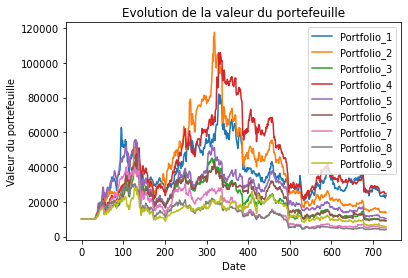

In [75]:
def UpdateValue(date, crypto_prices, portfolio_compo,initial_value):
    if len(portfolio_compo) == 0:
        return initial_value
    portfolio_value = 0
    for crypto, value in portfolio_compo.items():
        portfolio_value += value * crypto_prices.loc[date, crypto]
    return portfolio_value


def UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices):
    portfolio_compo.clear()
    portefeuille_actuelle = portfolios_df.loc[date, f"Portfolio_{portfolio_index}"]
    for crypto_name in portefeuille_actuelle:
        portfolio_compo[crypto_name] = portfolio_value / (10* crypto_prices.loc[date, crypto_name])
        
    


def compute_portfolio_values(crypto_prices, rebalancing_dates, portfolio_index, horizon, initial_value):
    portfolio_compo = {}
    portfolio_values = [initial_value]
    portfolio_value = initial_value

    for date in crypto_prices.index:
        portfolio_value = UpdateValue(date, crypto_prices, portfolio_compo,initial_value)
        if date in rebalancing_dates:
            UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices)
        portfolio_values.append(portfolio_value)

    return portfolio_values

# Initialiser la valeur initiale du portefeuille
initial_portfolio_value = 10000  # Par exemple, 10000 USD


# Indices de portefeuille à considérer
portfolio_indices = range(1, 10)

# Calculer les valeurs des portefeuilles pour les dates de rééquilibrage
portfolio_values_dict = {}

for portfolio_index in portfolio_indices:
    portfolio_values = compute_portfolio_values(crypto_prices, rebalancing_dates, portfolio_index, horizon=15, initial_value=initial_portfolio_value)
    portfolio_values_dict[f"Portfolio_{portfolio_index}"] = portfolio_values

# Afficher les graphiques pour chaque indice de portefeuille
for portfolio_index, portfolio_values in portfolio_values_dict.items():
    plt.plot(portfolio_values, label=portfolio_index)

plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()
plt.show()

